In [1]:
# 第一部分：导入必要的库和包
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, LSTM, GRU, SimpleRNN
from tensorflow.keras.losses import Huber
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 设置 Matplotlib 样式
plt.style.use("ggplot")

# 打印 TensorFlow 版本（确保环境正确配置）
print(f"TensorFlow Version: {tf.__version__}")

# 提示即将加载数据
print("数据加载脚本准备中，下一步将加载 HDF5 文件和预处理数据。")


TensorFlow Version: 2.18.0
数据加载脚本准备中，下一步将加载 HDF5 文件和预处理数据。


In [2]:
# 第二部分：加载 HDF5 文件并提取数据
# 定义文件路径
f1 = h5py.File("Phase_2/cushion_twophase100x100x50v5.h5", 'r')
f2 = h5py.File("Phase_2/cushion_twophase100x100x100v0.005.h5", 'r')
f3 = h5py.File("Phase_2/cushion_twophase200x200x100v0.005.h5", 'r')
f4 = h5py.File("Phase_2/cushion_twophase200x200x100v0.005.h5", 'r')
f5 = h5py.File("Phase_2/cushion_twophase200x200x100v0.05.h5", 'r')
f6 = h5py.File("Phase_2/cushion_twophase200x200x100v5.h5", 'r')
f7 = h5py.File("Phase_2/cushion_twophase200x200x100v5000.h5", 'r')

# 文件列表
f_all = [f1, f2, f3, f4, f5, f6, f7]

# 定义需要提取的数据模板路径和功能名称
template_paths = [
    "Function/CS/{i}", "Function/FS/{i}", "Function/JS/{i}",
    "Function/KF/{i}", "Function/P_S/{i}", "Function/S_S/{i}", 
    "Function/T_S/{i}", "Function/eigS1_CS/{i}", "Function/eigS2_CS/{i}", 
    "Function/eigS3_CS/{i}", "Function/gradp/{i}", "Function/nS/{i}",
    "Function/p/{i}", "Function/rhoFR/{i}", "Function/uS/{i}",
    "Function/wFR/{i}", "Mesh/mesh/geometry", "Mesh/mesh/topology"
]

functions = ["Function/CS", "Function/FS", "Function/JS",
"Function/KF", "Function/P_S", "Function/S_S", 
"Function/T_S", "Function/eigS1_CS", "Function/eigS2_CS", 
"Function/eigS3_CS", "Function/gradp", "Function/nS",
"Function/p", "Function/rhoFR", "Function/uS",
"Function/wFR"]

# 数据存储
data = []

In [3]:
# 提取所有文件中的相关数据
for f in f_all:
    file_data = {}
    for func in functions:
        try:
            file_data[func] = np.array(f[func])
        except KeyError:
            print(f"Key {func} not found in file {f.filename}")
            file_data[func] = None  # 如果某个功能路径不存在，置为 None
    data.append(file_data)

In [4]:
# 提取 uS（Solid Displacement）作为目标值，其他变量作为特征
features = []
targets = []

for file_data in data:
    if file_data["Function/uS"] is not None:
        features.append(np.hstack([file_data[func] for func in functions if file_data[func] is not None]))
        targets.append(file_data["Function/uS"])

# 转换为 NumPy 数组
X = np.concatenate(features, axis=0)
y = np.concatenate(targets, axis=0)

In [5]:
print(f"Length of features: {len(features)}")
print(f"Shape of first feature array: {features[0].shape if len(features) > 0 else 'Empty'}")
print(f"Length of targets: {len(targets)}")
print(f"Shape of first target array: {targets[0].shape if len(targets) > 0 else 'Empty'}")

Length of features: 7
Shape of first feature array: (784,)
Length of targets: 7
Shape of first target array: (49,)


In [6]:
# 提取所有文件中的相关数据
data = []
for f in f_all:
    file_data = {}
    for func in functions:
        try:
            file_data[func] = np.array(f[func])
        except KeyError:
            print(f"Key {func} not found in file {f.filename}")
            file_data[func] = None  # 如果某个功能路径不存在，置为 None
    data.append(file_data)

# 提取 uS（Solid Displacement）作为目标值，其他变量作为特征
features = []
targets = []

for file_data in data:
    if file_data["Function/uS"] is not None:
        # 将每个特征数组重塑为二维数组
        feature_array = np.hstack([
            file_data[func].reshape(-1, 1) for func in functions if file_data[func] is not None
        ])
        target_array = file_data["Function/uS"].reshape(-1, 1)  # 目标值也需要重塑
        features.append(feature_array)
        targets.append(target_array)

# 转换为 NumPy 数组
X = np.vstack(features)  # 按行拼接所有文件的特征
y = np.vstack(targets)   # 按行拼接所有文件的目标

# 数据预处理：归一化
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# 数据集划分
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# 数据形状打印
print(f"Feature shape after scaling: {X_train.shape}")
print(f"Target shape after scaling: {y_train.shape}")


Feature shape after scaling: (358, 16)
Target shape after scaling: (358, 1)


In [7]:
# 第三部分：构建 RNN 模型
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 构建模型
model = Sequential([
    # LSTM 层
    LSTM(64, activation='tanh', input_shape=(X_train.shape[1], 1), return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='tanh', return_sequences=False),
    Dropout(0.2),
    # 全连接层
    Dense(16, activation='relu'),
    Dense(1)  # 输出层，单一预测目标
])

# 编译模型
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])


# 模型摘要
model.summary()


D:\edu\anacoda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 16, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# 调整数据形状以适配 LSTM 层
X_train_rnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_rnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"RNN Input Shape (X_train): {X_train_rnn.shape}")
print(f"RNN Input Shape (X_test): {X_test_rnn.shape}")


RNN Input Shape (X_train): (358, 16, 1)
RNN Input Shape (X_test): (90, 16, 1)


In [9]:
# 训练模型
history = model.fit(
    X_train_rnn, y_train,
    epochs=50,  # 可根据实际情况调整
    batch_size=16,
    validation_data=(X_test_rnn, y_test),
    verbose=1
)


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - loss: 0.0392 - mae: 0.1156 - mse: 0.0392 - val_loss: 0.0032 - val_mae: 0.0444 - val_mse: 0.0032
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0039 - mae: 0.0351 - mse: 0.0039 - val_loss: 0.0034 - val_mae: 0.0388 - val_mse: 0.0034
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0029 - mae: 0.0286 - mse: 0.0029 - val_loss: 0.0023 - val_mae: 0.0259 - val_mse: 0.0023
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0017 - mae: 0.0197 - mse: 0.0017 - val_loss: 2.9421e-04 - val_mae: 0.0066 - val_mse: 2.9421e-04
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0017 - mae: 0.0208 - mse: 0.0017 - val_loss: 8.5875e-05 - val_mae: 0.0055 - val_mse: 8.5875e-05
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.6464e-04 - mae: 0.0141 - mse: 9.6464e-04 - val_loss: 9.4149e-05 - val_mae: 0.0045 - val_mse: 9.4149e-05
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0014 - mae: 0

In [10]:
# 将训练历史转换为 DataFrame
hist = pd.DataFrame(history.history)

# 显示训练历史的前几行
print(hist.head())


       loss       mae       mse  val_loss   val_mae   val_mse
0  0.020992  0.085725  0.020992  0.003171  0.044434  0.003171
1  0.002875  0.027728  0.002875  0.003427  0.038800  0.003427
2  0.002807  0.026558  0.002807  0.002308  0.025855  0.002308
3  0.001295  0.017784  0.001295  0.000294  0.006645  0.000294
4  0.001427  0.018264  0.001427  0.000086  0.005504  0.000086


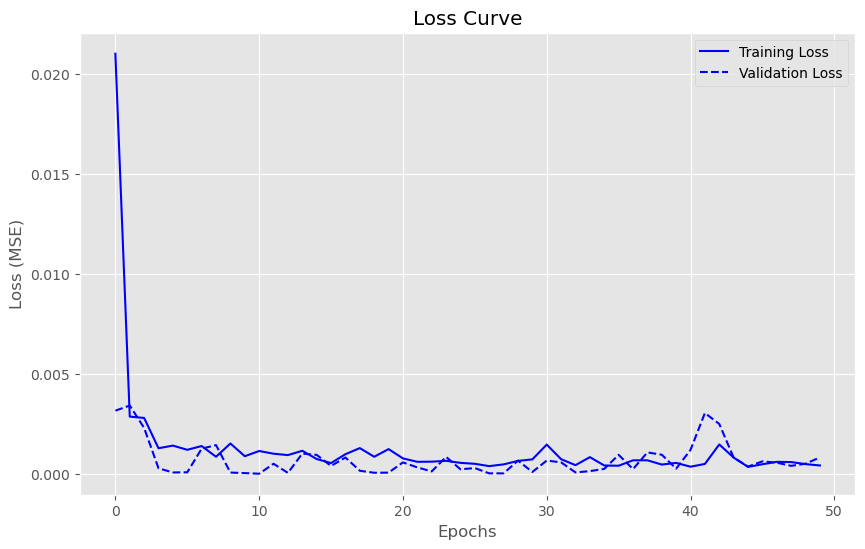

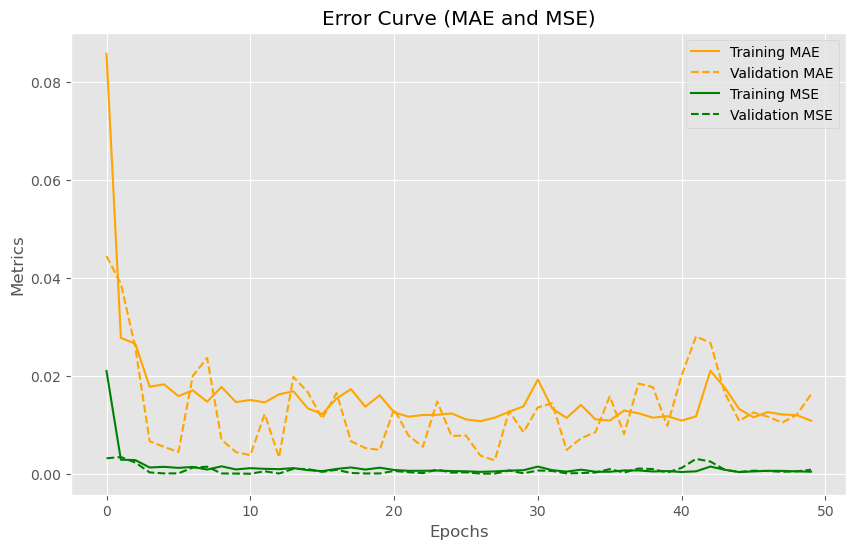

In [11]:
# 转换训练历史为 DataFrame
hist = pd.DataFrame(history.history)

# 绘制损失曲线
plt.figure(figsize=(10, 6))
plt.plot(hist['loss'], label='Training Loss', color='blue')
plt.plot(hist['val_loss'], label='Validation Loss', linestyle='dashed', color='blue')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# 绘制误差曲线
plt.figure(figsize=(10, 6))
plt.plot(hist['mae'], label='Training MAE', color='orange')
plt.plot(hist['val_mae'], label='Validation MAE', linestyle='dashed', color='orange')
plt.plot(hist['mse'], label='Training MSE', color='green')
plt.plot(hist['val_mse'], label='Validation MSE', linestyle='dashed', color='green')
plt.title('Error Curve (MAE and MSE)')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()
